In [1]:
#model trainings are differernt in the two notebooks
import pandas as pd
import scanpy as sc
import anndata as ad
import os
import numpy as np


In [2]:
data_dir = '/home/jing/Phd_project/project_UCD_blca/blca_DATA/blca_DATA_GSE135337/'
os.chdir(data_dir)

In [3]:
names_list = ["GSM4006644_BC1", "GSM4006647_BC4" ,"GSM4006648_BC5", "GSM4751267_BC6" ,"GSM4751268_BC7"]

GSM4006644_BC1


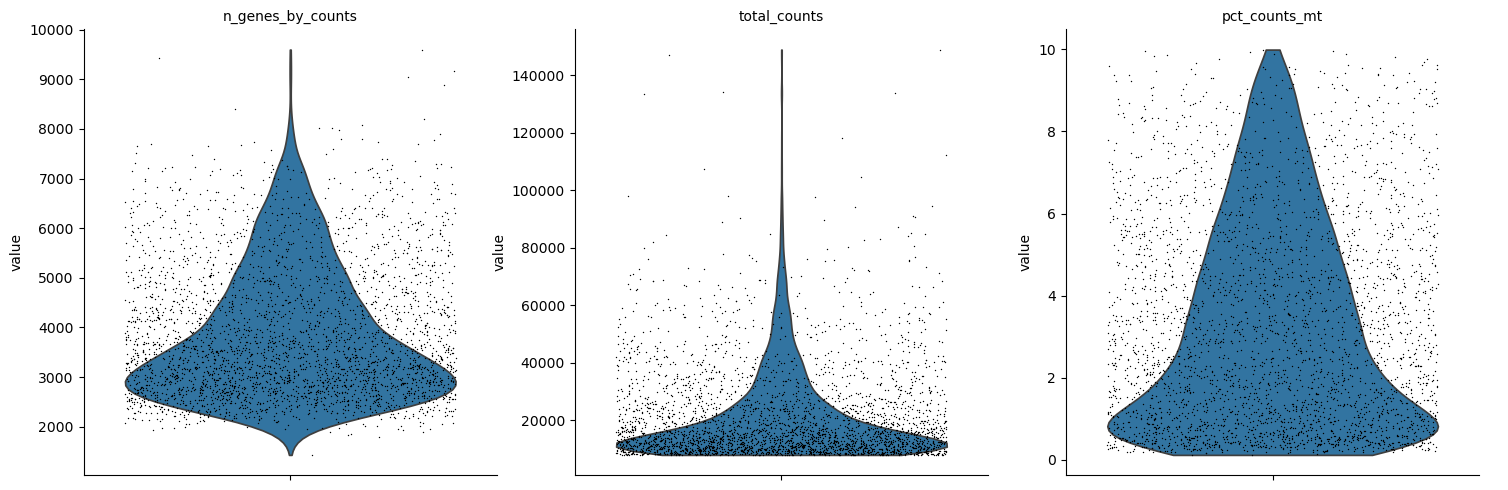

/tmp/ipykernel_1219986/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006647_BC4


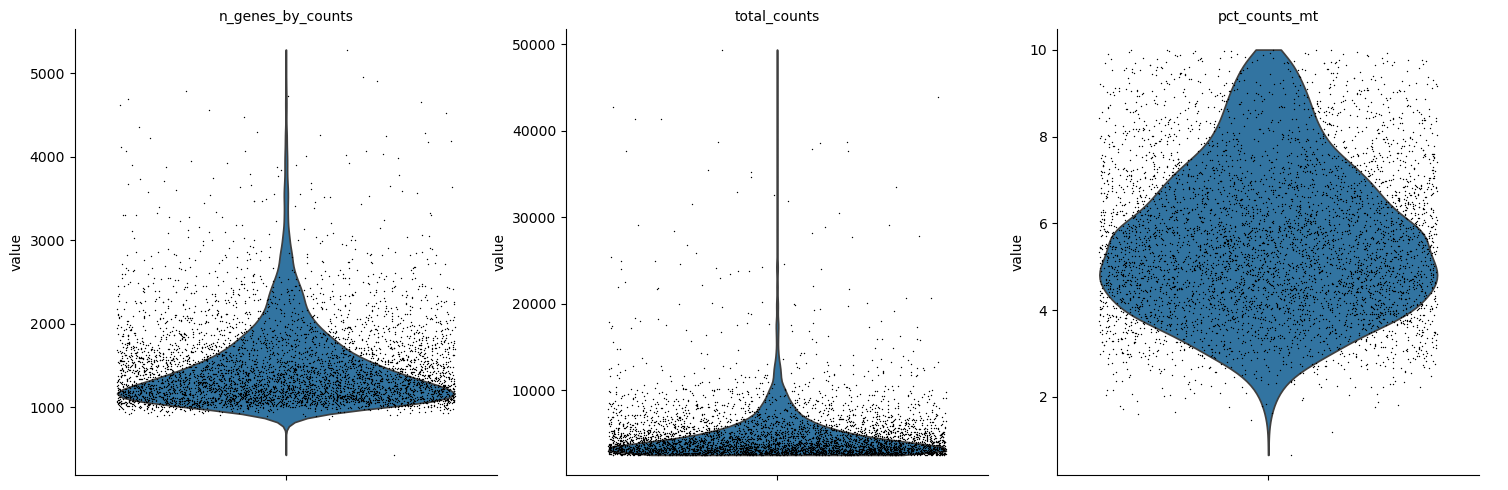

/tmp/ipykernel_1219986/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4006648_BC5


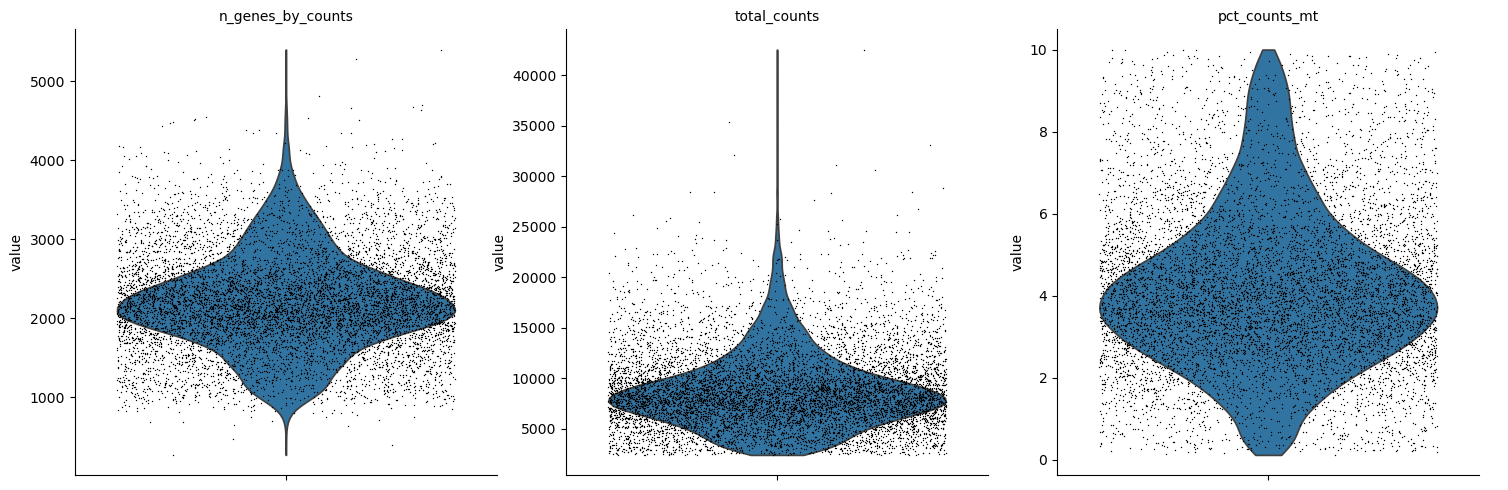

/tmp/ipykernel_1219986/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751267_BC6


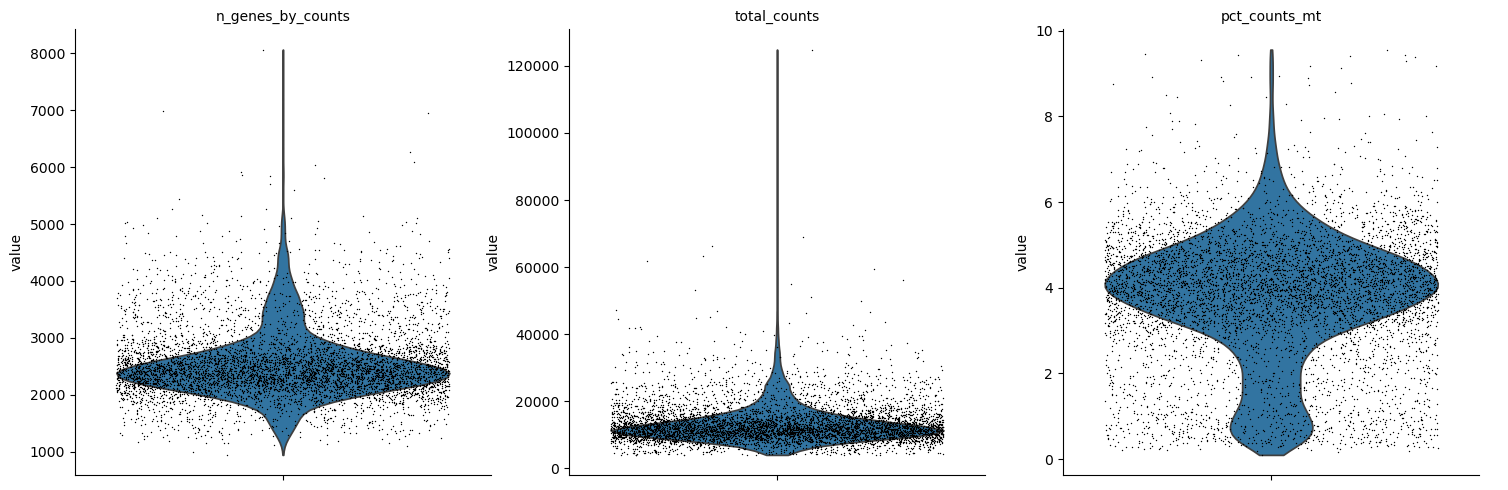

/tmp/ipykernel_1219986/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


GSM4751268_BC7


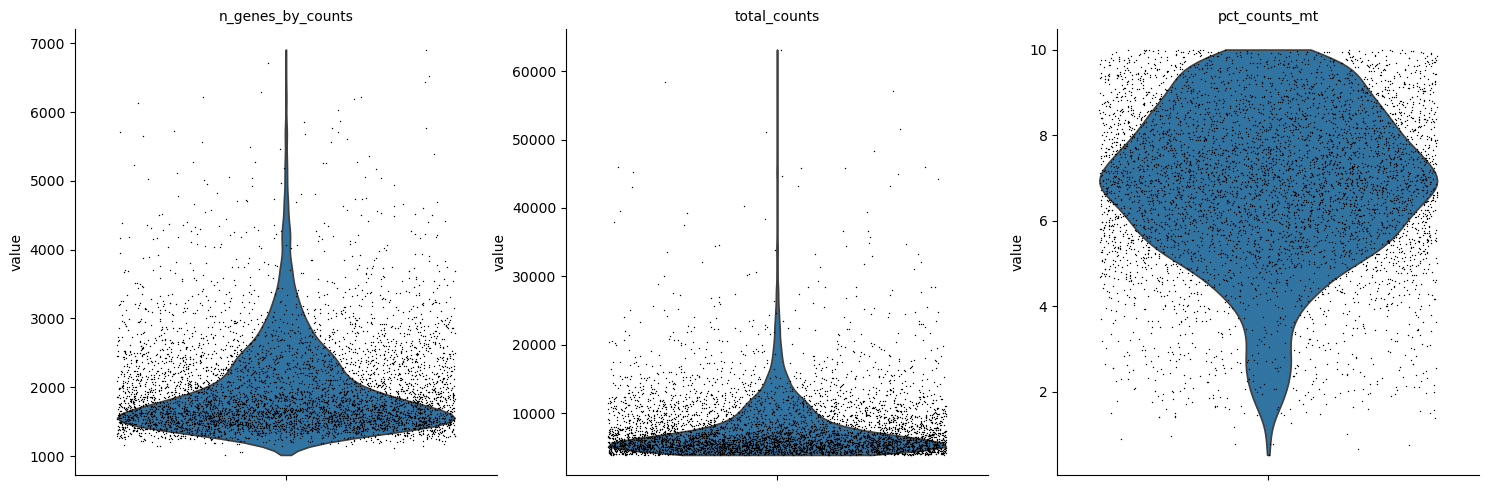

/tmp/ipykernel_1219986/2088865276.py:35: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['source'] = name


In [4]:
adata_list = []

# Loop over each sample and read in the AnnData object
for name in names_list:
    file_path = f"{name}_gene_cell_exprs_table.txt.gz"
    df = pd.read_csv(file_path, sep='\t')
    df.index = df.iloc[:, 0]
    gene_symbols = df.iloc[:,:2]

    # Drop the first two columns (Ensembl ID and gene name)
    df = df.iloc[:, 2:]
    # Transpose so that cells are rows and genes are columns
    df = df.T

    adata = ad.AnnData(df)

    adata.obs['CellID']= df.index
    adata.var[['Ensemble_ID','Gene']]= gene_symbols
    adata.var.index= adata.var['Gene']
    adata.var_names_make_unique() 
    adata.var['mt'] =adata.var_names.str.startswith('MT-')

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    print(name)
    sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True)
    
    adata= adata[adata.obs.n_genes_by_counts <6001, :]
    #adata= adata[adata.obs.pct_counts_mt< 5, :].copy()

    adata.obs['source'] = name
    adata.layers["counts"] = adata.X.copy()    

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata.raw = adata  # keep full dimension safe
    adata_list.append(adata)
    

In [5]:
batch_names = [adata.obs['source'].iloc[0] for adata in adata_list]
adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)                                  

/tmp/ipykernel_1219986/1379501109.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_list[0].concatenate(adata_list[1:], batch_key='source', batch_categories=batch_names)


In [6]:
immune_remove = pd.read_pickle('/home/jing/Phd_project/project_UCD_blca/blca_publication_OUTPUT/immune_cells_obs.pkl')

In [7]:
adata_non_immune = adata[~adata.obs.index.isin(immune_remove.index),]
adata_non_immune


View of AnnData object with n_obs × n_vars = 27864 × 13656
    obs: 'CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'source'
    var: 'mt', 'Ensemble_ID-GSM4006644_BC1', 'Gene-GSM4006644_BC1', 'n_cells_by_counts-GSM4006644_BC1', 'mean_counts-GSM4006644_BC1', 'pct_dropout_by_counts-GSM4006644_BC1', 'total_counts-GSM4006644_BC1', 'Ensemble_ID-GSM4006647_BC4', 'Gene-GSM4006647_BC4', 'n_cells_by_counts-GSM4006647_BC4', 'mean_counts-GSM4006647_BC4', 'pct_dropout_by_counts-GSM4006647_BC4', 'total_counts-GSM4006647_BC4', 'Ensemble_ID-GSM4006648_BC5', 'Gene-GSM4006648_BC5', 'n_cells_by_counts-GSM4006648_BC5', 'mean_counts-GSM4006648_BC5', 'pct_dropout_by_counts-GSM4006648_BC5', 'total_counts-GSM4006648_BC5', 'Ensemble_ID-GSM4751267_BC6', 'Gene-GSM4751267_BC6', 'n_cells_by_counts-GSM4751267_BC6', 'mean_counts-GSM4751267_BC6', 'pct_dropout_by_counts-GSM4751267_BC6', 'total_counts-GSM4751267_BC6', 'Ensemble_ID-GSM4751268_BC7', 'Gene-GSM4751268_BC7', '

In [8]:
adata_non_immune.raw = adata_non_immune  # keep full dimension safe
sc.pp.highly_variable_genes(
    adata_non_immune,
    flavor="seurat_v3",
    n_top_genes=2000,
    layer="counts",
    batch_key="source",
    subset=True,
)

In [16]:
from scipy.sparse import csr_matrix
adata_non_immune = adata_non_immune[:, adata_non_immune.var["highly_variable"]]  # focus on selected genes
adata_non_immune.layers["counts"] = csr_matrix(adata_non_immune.X.copy()).tocsr()



/tmp/ipykernel_1219986/1849500845.py:3: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_non_immune.layers["counts"] = csr_matrix(adata_non_immune.X.copy()).tocsr()


In [18]:
import scvi

# Make a copy of the adata object before setting up anndata
adata_non_immune_copy = adata_non_immune.copy()

# Now you can proceed with setup_anndata
scvi.model.SCVI.setup_anndata(adata_non_immune_copy, layer="counts", batch_key="source")

In [19]:
model = scvi.model.SCVI(
    adata_non_immune_copy, gene_likelihood="nb"
)  # We use Negative Binomial count likelihoods, following Boyeau et al., 2023.
model.train(
    check_val_every_n_epoch=1,
    max_epochs=400,
    early_stopping=True,
    early_stopping_patience=20,
    early_stopping_monitor="elbo_validation",
)

/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/jing/miniforge3/envs/cstar/lib/python3.12/site ...
/home/jing/miniforge3/envs/cstar/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bo

Training:   0%|          | 0/400 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


<Axes: xlabel='epoch'>

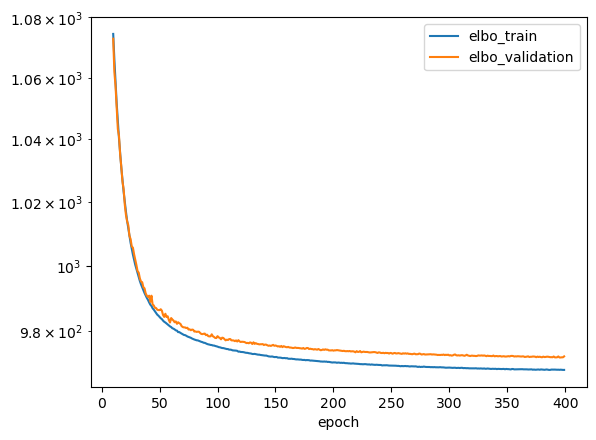

In [20]:
# Ensure convergence
train_test_results = model.history["elbo_train"]
train_test_results["elbo_validation"] = model.history["elbo_validation"]
train_test_results.iloc[10:].plot(logy=True)  # exclude first 10 epochs
#plt.show()

In [ ]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata_non_immune_copy.obsm[SCVI_LATENT_KEY] = latent
sc.pp.neighbors(adata_non_immune_copy, use_rep=SCVI_LATENT_KEY)

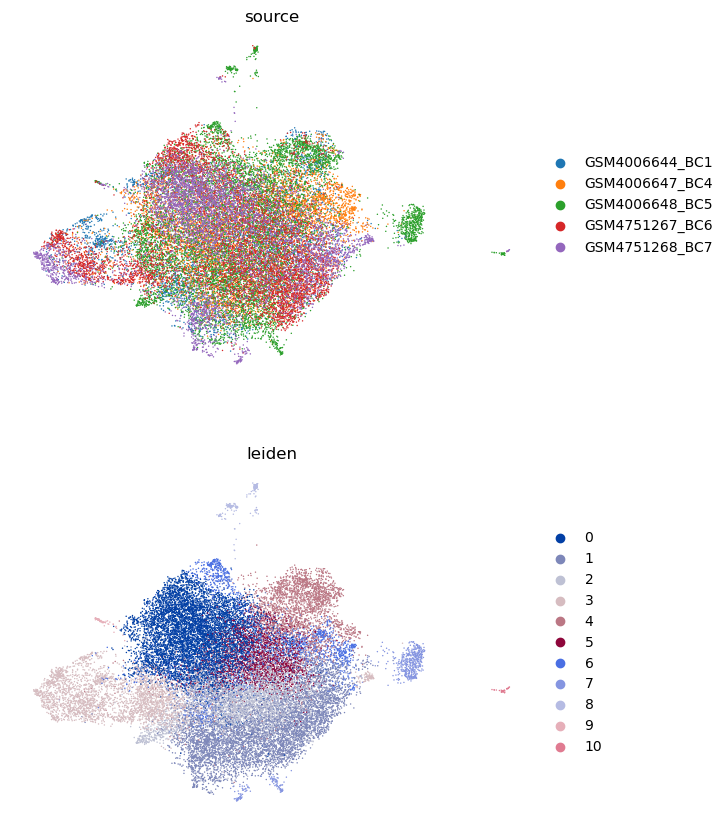

In [26]:
sc.tl.leiden(adata_non_immune_copy,resolution=0.5)
sc.tl.umap(adata_non_immune_copy, min_dist=0.3)
sc.pl.umap(
    adata_non_immune_copy,
    color=["source", "leiden"],
    frameon=False,
    ncols=1,
)

In [27]:
adata_non_immune_copy.obs['Stage'] = 'Ta'
adata_non_immune_copy.obs.loc[adata_non_immune_copy.obs['source'] == 'GSM4006647_BC4', 'Stage'] = 'T2'
adata_non_immune_copy.obs.loc[adata_non_immune_copy.obs['source'] == 'GSM4006648_BC5', 'Stage'] = 'T3'

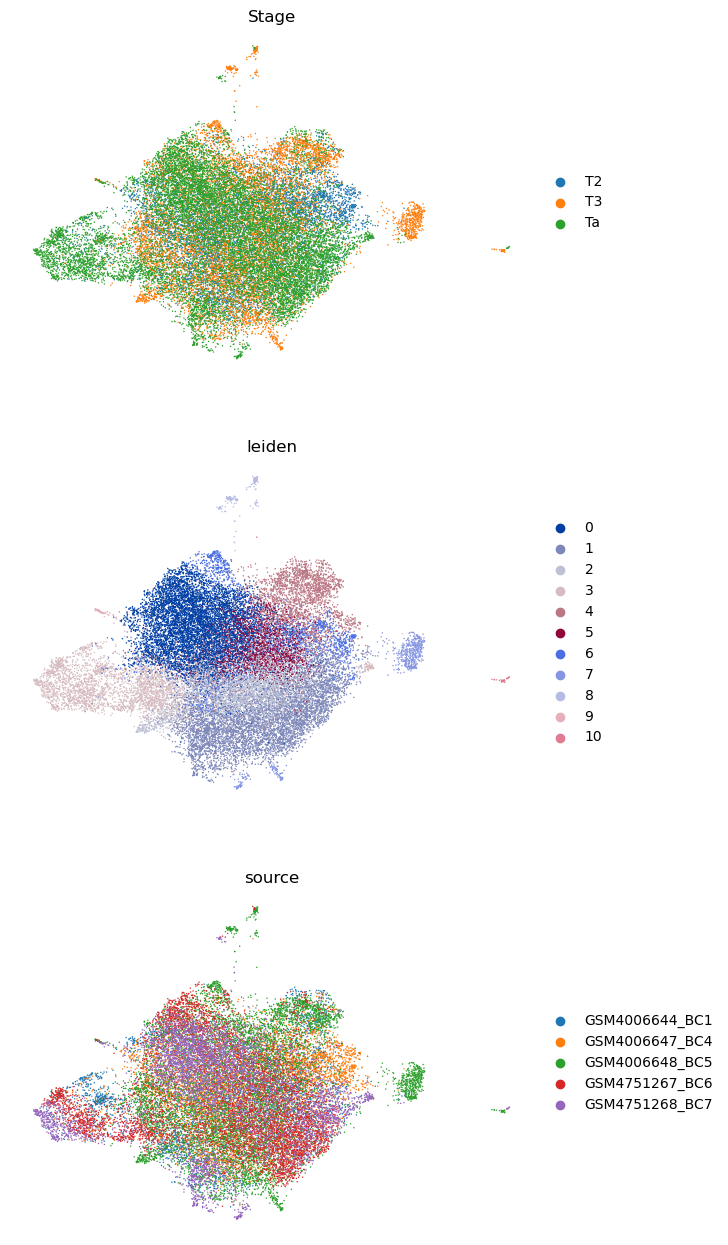

In [28]:
sc.pl.umap(
    adata_non_immune_copy,
    color=[ 'Stage',"leiden","source"],
    frameon=False,
    ncols=1,
)

In [ ]:
cell_type_1 = "Ciliated_non_amphid_neuron"
cell_idx1 = adata.obs["cell_type"] == cell_type_1
print(sum(cell_idx1), "cells of type", cell_type_1)

cell_type_2 = "Intestine"
cell_idx2 = adata.obs["cell_type"] == cell_type_2
print(sum(cell_idx2), "cells of type", cell_type_2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

In [ ]:
de_change = model.differential_expression(idx1=cell_idx1, idx2=cell_idx2)
de_change